In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.contrib import slim
import os
import tarfile
from six.moves import urllib

In [2]:
from tensorflow.contrib.slim.nets import vgg

In [3]:
## tfrecord file 이름과 디렉토리 설정
tfrecord_train = 'train.tfrecord'
tfrecord_test = 'test.tfrecord'
tfrecord_dir = 'tfrecords'

In [4]:
## tfrecord file 경로 설정
cur_dir = os.getcwd()
train_tfr_path = os.path.join(cur_dir, tfrecord_dir, tfrecord_train)
test_tfr_path = os.path.join(cur_dir, tfrecord_dir, tfrecord_test)

In [30]:
## hyper parameters
learning_rate = 0.001
training_epochs = 20
batch_size = 10

## input image size
img_height = 224
img_width = 224

## class 갯수
n_class = 10
## training data 수
n_train = 5000
## test data 수
n_test = 1000
## learning rate decay ratio
lr_decay_ratio = 0.1
## 몇 epoch 마다 learning rate을 decay할 것인지
lr_decay_epoch_num = 10
## image file 위치
#image_dir = 'caltech101'
image_dir = 'korean_food_10'

## Prepare Dataset

In [6]:
def _parse_function(tfrecord_serialized):
    features={'image': tf.FixedLenFeature([], tf.string),
             'label': tf.FixedLenFeature([], tf.int64)}
    parsed_features = tf.parse_single_example(tfrecord_serialized, features)
    
    image = tf.decode_raw(parsed_features['image'], tf.uint8)
    label = tf.cast(parsed_features['label'], tf.int32)
    #label_onehot = tf.one_hot(label, depth=n_class)
        
    #image = tf.reshape(image, [-1, img_height, img_width, 3])
    
    return image, label

In [7]:
train_dataset = tf.data.TFRecordDataset(train_tfr_path)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=8)
train_dataset = train_dataset.shuffle(buffer_size=n_train*2).prefetch(buffer_size=batch_size).batch(batch_size).repeat()
#print(train_dataset.output_types, train_dataset.output_shapes)

In [8]:
test_dataset = tf.data.TFRecordDataset(test_tfr_path)
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=8)
test_dataset = test_dataset.shuffle(buffer_size=n_train*2).prefetch(buffer_size=batch_size).batch(batch_size).repeat()
#print(test_dataset.output_types, test_dataset.output_shapes)

In [9]:
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
images, labels = iterator.get_next()

In [10]:
train_init = iterator.make_initializer(train_dataset)
test_init = iterator.make_initializer(test_dataset)

In [11]:
images = tf.reshape(images, [-1, 224, 224, 3])
images = tf.cast(images, tf.float32)
resized_images = tf.image.resize_images(images, (224, 224))

labels = tf.reshape(labels, (-1,))
onehot_labels = tf.one_hot(labels, 10)

## Download Pretrained Model's Checkpoint

In [12]:
ckpt_dir = "ckpt"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

In [13]:
ckpt_url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"
zpath = os.path.join(ckpt_dir, "vgg_16_2016_08_28.tar.gz")
if not os.path.exists(zpath):
    print ("Downloading %s ..." % (zpath))
    urllib.request.urlretrieve(ckpt_url, zpath)
    print ("Done!")
else:
    print ("%s Already Exists" % (zpath))

ckpt\vgg_16_2016_08_28.tar.gz Already Exists


## Unzip Checkpoint

In [14]:
cpath = os.path.join(ckpt_dir, "vgg_16_2016_08_28")
if not os.path.exists(cpath):
    print ("Extracting %s ..." % (cpath))
    tar = tarfile.open(zpath, "r:gz")
    tar.extractall(path=cpath)
    tar.close()
    print ("Done!")
else:
    print ("%s Already Exists" % (cpath))

ckpt\vgg_16_2016_08_28 Already Exists


## Model

In [15]:
with slim.arg_scope(vgg.vgg_arg_scope()):
    mean = tf.constant([123.68, 116.78, 103.94], dtype=tf.float32, shape=[1,1,1,3])
    im_centered = resized_images - mean
    logits, end_points = vgg.vgg_16(inputs=im_centered, num_classes=10, is_training=True)
    preds = tf.nn.softmax(logits, axis=-1)

In [16]:
preds

<tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float32>

In [17]:
tf.trainable_variables()

[<tf.Variable 'vgg_16/conv1/conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_2/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_1/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_2/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_2/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_1/weights:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_1/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_2/weights:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_2/biases:0' shape=(256,) dtype=float32_

## Fine Tuning

In [18]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=onehot_labels))
#global_step = tf.Variable(0, trainable=False)
#lr_decay = tf.train.exponential_decay(learning_rate=learning_rate,
#                                          global_step= global_step,
#                                          decay_steps=int(n_train/batch_size*lr_decay_epoch_num),
#                                          decay_rate= lr_decay_ratio,
#                                          staircase=True)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

In [19]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(onehot_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [20]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))

In [21]:
sess.run(tf.global_variables_initializer())

In [22]:
ckpt_name = "vgg_16.ckpt"
ckpt_path = os.path.join(cpath, ckpt_name)

exclude = ['vgg_16/fc8']
variables_to_restore = slim.get_variables_to_restore(exclude=exclude)
saver = tf.train.Saver(variables_to_restore)

saver.restore(sess, ckpt_path)

INFO:tensorflow:Restoring parameters from ckpt\vgg_16_2016_08_28\vgg_16.ckpt


In [23]:
# train my model
print('Learning started. It takes sometime.')
max_test_acc = 0.
for epoch in range(training_epochs):
    avg_cost = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    
    total_batch = int(n_train / batch_size)
    total_batch_test = int(n_test / batch_size)
    
    sess.run(train_init)
    for i in range(total_batch):
        acc, c, _ = sess.run([accuracy, cost, optimizer])
        avg_cost += c / total_batch
        avg_train_acc += acc / total_batch
        if i % 100 == 0:
            print("{} Epoch : {} images were used for training".format(epoch+1, i*10))
        
    sess.run(test_init)        
    for i in range(total_batch_test):
        acc = sess.run(accuracy)
        avg_test_acc += acc / total_batch_test
        if i == 50:
            print("Calculating test accuracy...")

    print('Epoch:', '{}'.format(epoch + 1), 'cost =', '{:.8f}'.format(avg_cost), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

Learning started. It takes sometime.
1 Epoch : 0 images were used for training
1 Epoch : 1000 images were used for training
1 Epoch : 2000 images were used for training
1 Epoch : 3000 images were used for training
1 Epoch : 4000 images were used for training
Calculating test accuracy...
Epoch: 1 cost = 1.17621494 train accuracy =  0.6230 test accuracy =  0.7890
2 Epoch : 0 images were used for training
2 Epoch : 1000 images were used for training
2 Epoch : 2000 images were used for training
2 Epoch : 3000 images were used for training
2 Epoch : 4000 images were used for training
Calculating test accuracy...
Epoch: 2 cost = 0.54357995 train accuracy =  0.8310 test accuracy =  0.7930
3 Epoch : 0 images were used for training
3 Epoch : 1000 images were used for training
3 Epoch : 2000 images were used for training
3 Epoch : 3000 images were used for training
3 Epoch : 4000 images were used for training
Calculating test accuracy...
Epoch: 3 cost = 0.31967030 train accuracy =  0.9004 test a

Calculating test accuracy...
Epoch: 25 cost = 0.00642255 train accuracy =  0.9980 test accuracy =  0.8670
26 Epoch : 0 images were used for training
26 Epoch : 1000 images were used for training
26 Epoch : 2000 images were used for training
26 Epoch : 3000 images were used for training
26 Epoch : 4000 images were used for training
Calculating test accuracy...
Epoch: 26 cost = 0.00739745 train accuracy =  0.9974 test accuracy =  0.8630
27 Epoch : 0 images were used for training
27 Epoch : 1000 images were used for training
27 Epoch : 2000 images were used for training
27 Epoch : 3000 images were used for training
27 Epoch : 4000 images were used for training
Calculating test accuracy...
Epoch: 27 cost = 0.01184803 train accuracy =  0.9968 test accuracy =  0.8670
28 Epoch : 0 images were used for training
28 Epoch : 1000 images were used for training
28 Epoch : 2000 images were used for training
28 Epoch : 3000 images were used for training
28 Epoch : 4000 images were used for training
C

In [33]:
cur_dir = os.getcwd()
image_path = os.path.join(cur_dir, image_dir)

class_names = sorted(os.listdir(image_path))
print(class_names)

['bibimbap', 'bulgogi', 'doenjang_chigae', 'galbijjim', 'ganjang_gejang', 'kimchi', 'nangmyeon', 'samgupsal', 'samgyetang', 'soondae']


In [42]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(n_class), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(n_class), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

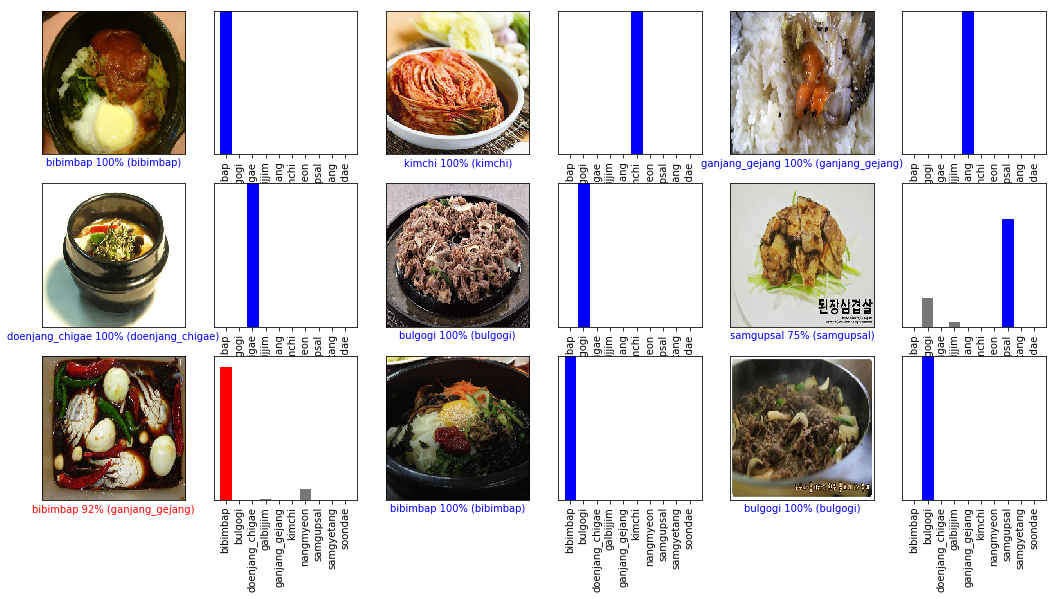

In [53]:
prob = tf.nn.softmax(logits)
imgs, lbs, x, y = sess.run([images, labels, resized_images, onehot_labels])
imgs = np.reshape(imgs, [-1, img_height, img_width, 3])/255.
predictions = sess.run(prob, feed_dict={resized_images:x, onehot_labels:y})
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(3*2*num_cols, 3*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, lbs, imgs)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, lbs)